In [1]:
#Importovanie potrebných knižníc
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import LSTM
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
#Importovanie dát pomocou pandas knižnice
train = pd.read_csv("bitcoin_price_Training - Training.csv")
test = pd.read_csv("bitcoin_price_1week_Test - Test.csv")

In [3]:
#Zobrazenie trenovacieho datasetu
train.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Jul 31, 2017",2763.24,2889.62,2720.61,2875.34,"860,575,000","45,535,800,000"
1,"Jul 30, 2017",2724.39,2758.53,2644.85,2757.18,"705,943,000","44,890,700,000"
2,"Jul 29, 2017",2807.02,2808.76,2692.80,2726.45,"803,746,000","46,246,700,000"
3,"Jul 28, 2017",2679.73,2897.45,2679.73,2809.01,"1,380,100,000","44,144,400,000"
4,"Jul 27, 2017",2538.71,2693.32,2529.34,2671.78,"789,104,000","41,816,500,000"


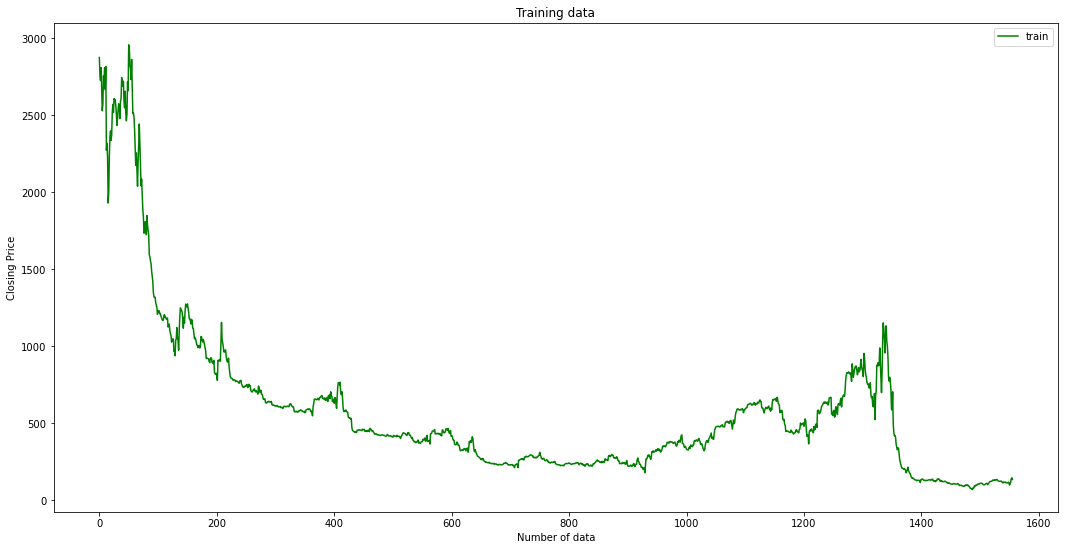

In [4]:
#Vizualizacia trenovacieho datasetu
plt.figure(figsize = (18,9))
plt.plot(train["Close"],'green', label='train')
plt.xlabel('Number of data')
plt.ylabel("Closing Price")
plt.legend()
plt.title("Training data")
plt.show()

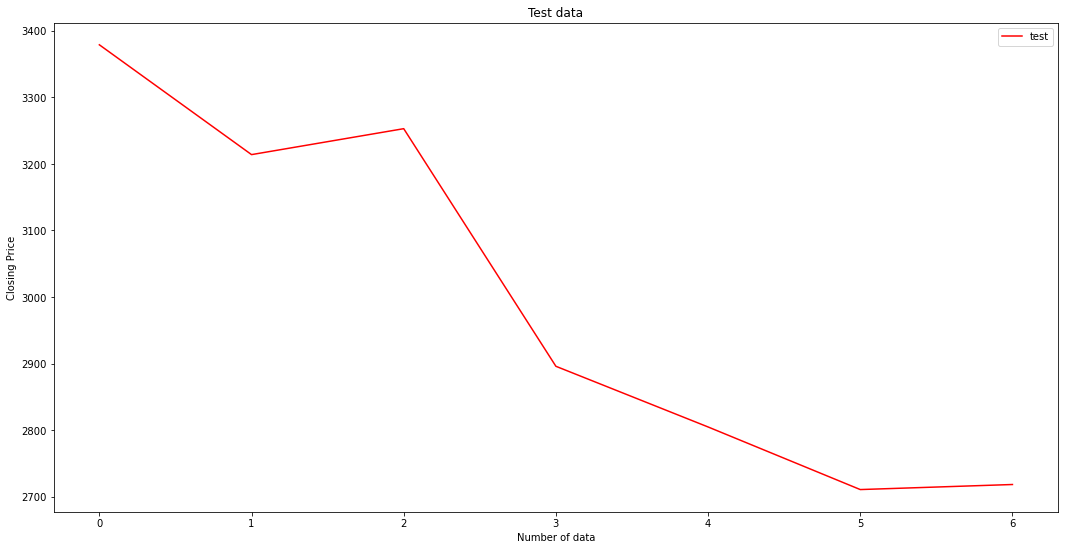

In [5]:
#Vizualizacia testovacieho datasetu
plt.figure(figsize = (18,9))
plt.plot(test["Close"],'red', label='test')
plt.xlabel('Number of data')
plt.ylabel("Closing Price")
plt.legend()
plt.title("Test data")
plt.show()


In [6]:
#Začiname od konca datasetu - najstaršieho dátumu
train = train[::-1]
test = test[::-1]


In [7]:
#Premena pandas objektu na float
train = train['Close'].values.astype('float32')
test = test['Close'].values.astype('float32')


In [8]:
# úprava poli a scalovanie udajov
train = train.reshape(-1, 1)
test = test.reshape(-1, 1)

scaler = StandardScaler()
train_n = scaler.fit_transform(train)
test_n = scaler.transform(test)

In [9]:
#data - pole našich údajov
#lookback - O koľko časových krokov späť by mali ísť naše vstupné údaje
#delay - koľko časových krokov v buducnosti je náš ciel
#min_index a max_index - indexy v dátovom poli, ktoré vymedzujú, z ktorých časových krokov sa má čerpať. 
#využívajú sa na validáciu a testovanie
#shuffle - určuje či data prehadzujeme alebo bereme v chronologickom poradí
#batch_size - velkosť várky
#step - Obdobie v časových krokoch, v ktorom vzorkujeme údaje.
#Nasledujúci krok definuje generátor, ktorý vytvára n-ticu (vzorky, ciele),
#kde vzorky sú jednou várkou vstupných údajov a cieľmi je zodpovedajúce pole cieľových hodnôt

def generator(data, lookback, delay, min_index, max_index, 
              shuffle=False, batch_size=128, step=1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
                
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay]
        yield samples, targets

In [10]:
lookback = 30 # v tomto pripade pouzívame 30 dni ako vstup na predikciu ďalšich 7 dni
step = 1 # - obdobie v časových krokoch, v ktorom vzorkujeme údaje.
delay = 7  # koľko časových krokov chceme predikovať
batch_size = 124 #- počet vzoriek

# generovanie setov dát
train_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=0, max_index=1000, shuffle=True, step=step,
batch_size=batch_size)
val_gen = generator(train_n, lookback=lookback, delay=delay,
    min_index=1001, max_index=None, step=step, batch_size=batch_size)
test_gen = generator(test_n, lookback=lookback, delay=delay,
    min_index=0, max_index=None, step=step, batch_size=batch_size)

val_steps = (len(train_n) - 1001 - lookback) // batch_size
#počet krokov koľko potrebujeme na zobrazenie celého validačného setu
test_steps = (len(test_n) - lookback) // batch_size
#počet krokov koľko potrebujeme na zobrazenie celého testovacieho setu

In [11]:
#slúži na reprodukovateľnosť
np.random.seed(5)

In [12]:
#Inicializacia  neuronovej siete
model = Sequential()
#Pridanie SimpleRNN vrstvy s aktivačnou funkciou relu 
model.add(layers.SimpleRNN(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     activation='relu',                         
                     input_shape=(None, train_n.shape[-1])))

#Vystupna vrstva
model.add(layers.Dense(1))
# RMS prop je adaptívny optimalizátor rýchlosti učenia, mae je chybová funkcia 
model.compile(optimizer=RMSprop(), loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [13]:
# na predpripravený model sa zavolá funkcia fit, ktorá berie ako vstupné parametre dáta z datasetu 

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=100,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/100
500/500 [==============================] - 7s 12ms/step - loss: 0.3021 - val_loss: 0.3081
Epoch 2/100
500/500 [==============================] - 5s 9ms/step - loss: 0.0840 - val_loss: 0.3599
Epoch 3/100
500/500 [==============================] - 5s 9ms/step - loss: 0.0781 - val_loss: 0.3793
Epoch 4/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0769 - val_loss: 0.4475
Epoch 5/100
500/500 [==============================] - 5s 10ms/step - loss: 0.0753 - val_loss: 0.4551
Epoch 6/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0748 - val_loss: 0.4558
Epoch 7/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0743 - val_loss: 0.4493
Epoch 8/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0744 - val_loss: 0.4588
Epoch 9/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0731 - val_loss: 0.5138
Epoch 10/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0736 - val

500/500 [==============================] - 4s 9ms/step - loss: 0.0640 - val_loss: 0.6410
Epoch 82/100
500/500 [==============================] - 5s 9ms/step - loss: 0.0647 - val_loss: 0.6004
Epoch 83/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0645 - val_loss: 0.4942
Epoch 84/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0656 - val_loss: 0.6559
Epoch 85/100
500/500 [==============================] - 5s 9ms/step - loss: 0.0649 - val_loss: 0.7664
Epoch 86/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0642 - val_loss: 0.5598
Epoch 87/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0667 - val_loss: 0.7783
Epoch 88/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0656 - val_loss: 0.7025
Epoch 89/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0645 - val_loss: 0.7425
Epoch 90/100
500/500 [==============================] - 4s 9ms/step - loss: 0.0648 - val_loss: 

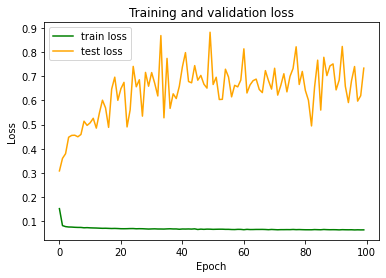

In [14]:
#Vizualizacia chybovosti
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.plot(epochs, loss, 'green', label='train loss')
plt.plot(epochs, val_loss, 'orange', label='test loss')
plt.title('Training and validation loss')
plt.legend()

In [15]:
#zmena tvaru pola a predikcia
train_re = train_n.reshape(-1,1,1)
prediction = model.predict(train_re)

In [16]:
#preskalovanie udajov
prediction = scaler.inverse_transform(prediction)


Text(0.5, 1.0, 'Prediction on training data')

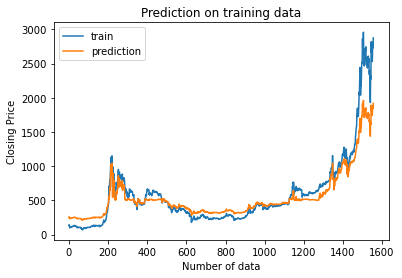

In [17]:
#Vizualizacia výsledkov
plt.plot(range(len(train_re)), train, label='train')
plt.plot(range(len(train_re)), prediction, label='prediction')
plt.xlabel('Number of data')
plt.ylabel("Closing Price")
plt.legend()
plt.title("Prediction on training data")